# TP de méta-heuristiques
## Algorithme du recuit simulé - Problème de placement de composants éléctroniques

Ce notebook présente l'utilisation de l'algorithme du recuit simulé pour résoudre l'optimisation du placement de composants éléctroniques.

La première cellule génère un tableau représentant le placement optimal pour les composants et de dimension 5x5.

In [1]:
import numpy as np
# Generation of organized array where each cell contain the her indice as a value 
b = [[(i,j) for j in range(1,6)] for i in range(1,6)]
a = np.array([[(i,j) for j in range(1,6)]for i in range(1,6)], dtype = [('x','<i4'),('y','<i4')])

print(a)

[[(1, 1) (1, 2) (1, 3) (1, 4) (1, 5)]
 [(2, 1) (2, 2) (2, 3) (2, 4) (2, 5)]
 [(3, 1) (3, 2) (3, 3) (3, 4) (3, 5)]
 [(4, 1) (4, 2) (4, 3) (4, 4) (4, 5)]
 [(5, 1) (5, 2) (5, 3) (5, 4) (5, 5)]]


### Fonction _getNeighs_

Cette fonction retourne les voisins de la cellule passée en paramètre (colomne i, ligne j) dans la matrice.

### Fonction _drawState_

Cette fonction affiche à l'écran l'état de la matrice passée en argument.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def getNeighs(i,j, Matrix):
    neigh = []
    x = Matrix[i][j][0]
    y = Matrix[i][j][1]
    n = Matrix.shape[0]
    for p in [-1,0, 1]:
        for k in [-1, 0,1]:
          if (abs(p) + abs(k) < 2) :
             # print(x,y,p,k)
              for l in range(n):
                  for e in range(n):
                      if ((((p + y) > 0) and (p + y <= n)) and (((k + x) > 0) and (k + x <= n))): 
                        if ((Matrix[l][e][0] == k + x) and  (Matrix[l][e][1] == p + y)):
                          neigh.append((l +1, e +1))
    return neigh
def draw_state(s):
    n = len(s)
    w = 1
    h = 1
    fig1 = plt.figure()
    for i in range(1,n + 1):
        for j in range(1, n + 1):
          ax1 = fig1.add_subplot(111, aspect='equal')
          ax1.add_patch(patches.Rectangle((i - w/4, j - h/4),w/2, h/2, fill = False))
          neighs = getNeighs(i - 1, j - 1, s)
          for cell in neighs:
            plt.plot([i, cell[0]  ], [j, cell[1]  ], 'k-', lw=2)

    ax1.set_axisbelow(True)
    ax1.xaxis.set_ticks_position("top")

    ax1.grid(linestyle='-', linewidth='0.5', color='red')
    fig1.savefig('rect1.png', dpi=90, bbox_inches='tight')
    plt.xticks([i + 1 for i in range(n)])
    plt.yticks([i + 1 for i in range(n)])
    plt.axis([0, n + 1, 0, n + 1])
    plt.gca().invert_yaxis()
    plt.show()

### Fonction _getList_

Cette fonction est utilisée pour récupérer les états intmermédiaires avec une énergie décroissante jusqu'à atteindre l'optimum.

In [3]:
def getList(mat):
    (n,m) = mat.shape  
    M =  (n * (m - 1) + m * (n - 1)) * 5
    step = int(M / 5)
    L = [i for i in range(2 * M, M - step, - step)]
    return L

In [4]:
getList(a)

[400, 360, 320, 280, 240, 200]

### Fonction _randomStateNeigh_

Cette fonction change la position des éléments de façon aléatoire dans la matrice passée en argument.

### Fonction _distCells_

Cette fonction calcul la distance entre deux cellule dans la matrice courante. La constante 5 correspond à l'estimation de l'énergie par arrête donnée par le sujet.

### Fonction _energySys_

Cette fonction calcul la distance totale de toutes les lignes et de toutes les colomnes de la matrice. Si deux éléments sont côtes à côte alors qu'il ne devraient pas, alors la distance totale L sera augmantée. Le problème se résume alors à minimiser cette distance L.

### Fonction _MetRcS_

Cette fonction contient la boucle principale du programme. A chaque itération, deux voisins seront changés aléatoirement. Si cette permutation permet de faire baisser lénergie du système alors celle-ci est conservée.

Au contraire, si celle-ci fait augmanter l'énergie du système, alors elle n'est conservée qu'en fonction d'une loi de probabilité exponentielle, fonction de la température du système. Cette probabilité permet de donner de la souplesse au système tout en l'empechant de diverger lorsqu'il se rapproche de l'optimal. En effet, la loi exponentielle étant fortement décroissante, les états à plus forte énéergie seront plus difficilement acceptés après un certain temps.

La température est déterminée au début du programme en fonction de son énergie initiale et contrôle la diminution de probabilité au cours de la convergence.

In [5]:
import random
import math
def randomStateNeigh(Matrix):
    n = Matrix.shape[0]
    m = Matrix.shape[1]
    i = random.randint(0, n - 1)
    j = random.randint(0, m - 1)
    cel = Matrix[i][j].copy()
    randx = np.random.choice([-1, 0,1])
    randy = np.random.choice([-1, 0,1])
    while( ((j + randx) < 0) or ((j + randx) >= m) ):
        randx = np.random.choice([-1,0,1])
    while( ((i + randy) < 0) or ((i + randy) >= n) ):
        randy = np.random.choice([-1,0 ,1])
    Matrix[i][j] = Matrix[randy + i][randx + j].copy()
    Matrix[randy + i][randx + j] = cel.copy()
    return Matrix
def distCells(cel1, cel2):
    cel1y = cel1[1]
    cel1x = cel1[0]
    cel2y = cel2[1]
    cel2x = cel2[0]
    return 5 * int(np.abs((cel1x - cel2x))+ np.abs((cel1y - cel2y)))
def energySys(matrix):
    n = matrix.shape[0]
    m = matrix.shape[1]
    L = 0
    for i in range(n):
      for j in range(m - 1):
        L += distCells(matrix[i][j], matrix[i][j + 1])
    for j in range(m):
      for i in range(n - 1):
        L += distCells(matrix[i][j], matrix[i + 1][j])
    return L
def MetRcS(randMatrix, emin):
    L = getList(randMatrix)
    idxL = 0
    s = randMatrix.copy()
    sk = s
    e = energySys(s)
    ek = e
    k = 1
    m = [np.abs(energySys(s) - energySys(randomStateNeigh(s.copy()))) for i in range(100)]
    delta = np.mean(m)
    T = delta / math.log(2)
    acc = 0
    tried = 0
    n = randMatrix.shape[0]
    while ((e > emin) and (k < 100000)):
        sk = randomStateNeigh(s.copy())
        ek = energySys(sk)
        if ((idxL < len(L)) and (ek <= L[idxL])):
          draw_state(sk)
          idxL += 1  
          print("energy",ek)
          print('temp ', T)
        if ((ek < e) or (random.random() <= math.exp(- abs((ek - e))/ T ))):
          s = sk.copy()
          e = ek
          acc += acc
        tried = tried + 1
        if ((tried == 100 * n) or (acc == 12 * n)):
          #print(ek)
          #print('temp ', T)
          T = T * 0.999
          acc = 0
          tried = 0
          k = 0
        k = k + 1
    return s
            

Le cellule suivante copie la matrice d'exemple a du début du TP et la rend aléatoire à l'aide de la fonction _randomStateNeigh_ vue précédemment.

In [6]:
b = a.copy()
randomStateNeigh(b)
b  

array([[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
       [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)],
       [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)],
       [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)],
       [(5, 1), (5, 2), (5, 4), (5, 3), (5, 5)]],
      dtype=[('x', '<i4'), ('y', '<i4')])

Le cellule suivante prrésente différentes itérations de l'algorithme jusqu'à atteindre l'état optimal.

225


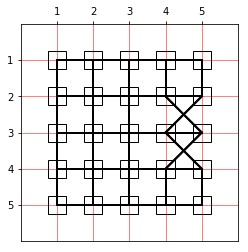

energy 225
temp  29.214574578


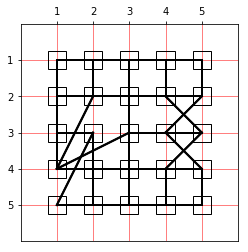

energy 255
temp  29.214574578


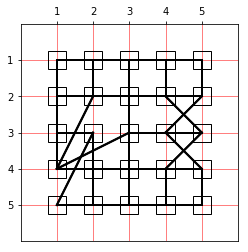

energy 255
temp  29.214574578


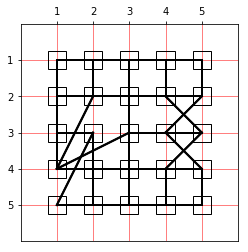

energy 255
temp  29.214574578


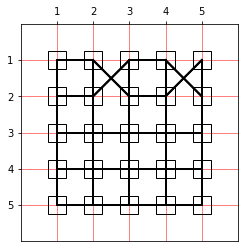

energy 235
temp  7.29342860362


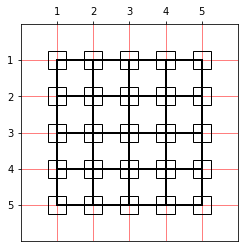

energy 200
temp  6.28961400317
[[(1, 5) (2, 5) (3, 5) (4, 5) (5, 5)]
 [(1, 4) (2, 4) (3, 4) (4, 4) (5, 4)]
 [(1, 3) (2, 3) (3, 3) (4, 3) (5, 3)]
 [(1, 2) (2, 2) (3, 2) (4, 2) (5, 2)]
 [(1, 1) (2, 1) (3, 1) (4, 1) (5, 1)]]


In [7]:
b = a.copy()
randomStateNeigh(b)
print(energySys(b))
d = MetRcS(b, 200)
print(d)